# Convolutional Autoencoder with MNIST

- fashion_mnist, cifar10 dataset 을 이용한 deep autoencoder 생성


- CNN을 이용하여 encoding 후 decoding 하여 복원

## Autoencoder using Conv2D
<table><tr><td><img src='autoencoder_simple.png'></td><td><img src='autoencoder_2.png'></td></tr></table>

- loss : pixel 단위의 binary crossentropy  

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import fashion_mnist, cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

## 이미지에 임의의 노이즈 추가

In [2]:
def add_noise(X_train, X_test, sigma):
    X_train_noisy = X_train + tf.random.normal(shape=X_train.shape, mean=0, stddev=sigma) 
    X_test_noisy = X_test + tf.random.normal(shape=X_test.shape, mean=0, stddev=sigma) 

    X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
    X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

    return X_train_noisy, X_test_noisy

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

In [4]:
# fashion mnist
(X_train, _), (X_test, _) = fashion_mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

# cifar10
# (X_train, _), (X_test, _) = cifar10.load_data()

X_train = X_train / 255.
X_test = X_test / 255.
X_train.shape, X_test.shape

4423680/4422102 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [9]:
#이미지에 임의의 노이즈 추가
sigma = 0.4

X_train_noisy, X_test_noisy = add_noise(X_train, X_test, sigma)
X_train_noisy.shape, X_test_noisy.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

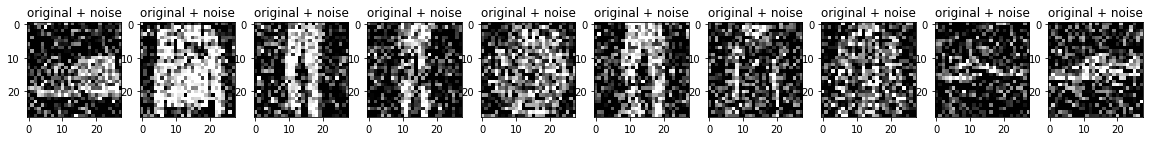

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test_noisy[i]))
    plt.gray()
plt.show()

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_noisy, X_train)) \
            .shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_ds = tf.data.Dataset.from_tensor_slices((X_test_noisy, X_test)) \
            .batch(BATCH_SIZE).repeat()

train_ds, test_ds

(<RepeatDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float64)>,
 <RepeatDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.float32, tf.float64)>)

# Convolutional autoencoder

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

In [12]:
input = Input(shape=(X_train.shape[1:]))

conv_1 = Conv2D(filters=64, kernel_size=(3,3), 
               activation='relu', padding='same')(input)
maxpool_1 = MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2 = Conv2D(filters=128, kernel_size=(3,3), 
               activation='relu', padding='same')(maxpool_1)
maxpool_2 = MaxPooling2D(pool_size=(2,2))(conv_2)

bottle_neck = Conv2D(filters=256, kernel_size=(3,3),
                activation='relu', padding='same', name='bottleneck')(maxpool_2)

conv_3 = Conv2D(filters=128, kernel_size=(3,3),
               activation='relu', padding='same')(bottle_neck)
upsample_3 = UpSampling2D(size=(2,2))(conv_3)

conv_4 = Conv2D(filters=64, kernel_size=(3,3), 
                activation='relu', padding='same')(upsample_3)
upsample_4 = UpSampling2D(size=(2,2))(conv_4)

conv_5 = Conv2D(filters=X_train.shape[3], kernel_size=(3,3), 
                activation='sigmoid', padding='same')(upsample_4)

# autoencoder model
autoencoder = Model(inputs=input, outputs=conv_5)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
bottleneck (Conv2D)          (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         295040

In [13]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
# encoder model for visualization
encoder_viz = Conv2D(filters=1, kernel_size=(3,3), 
                     activation='relu', padding='same')(bottle_neck)
encoder_model = Model(inputs=input, outputs=encoder_viz)

In [15]:
encoder_viz.shape

TensorShape([None, 7, 7, 1])

In [16]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
bottleneck (Conv2D)          (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 1)           2305

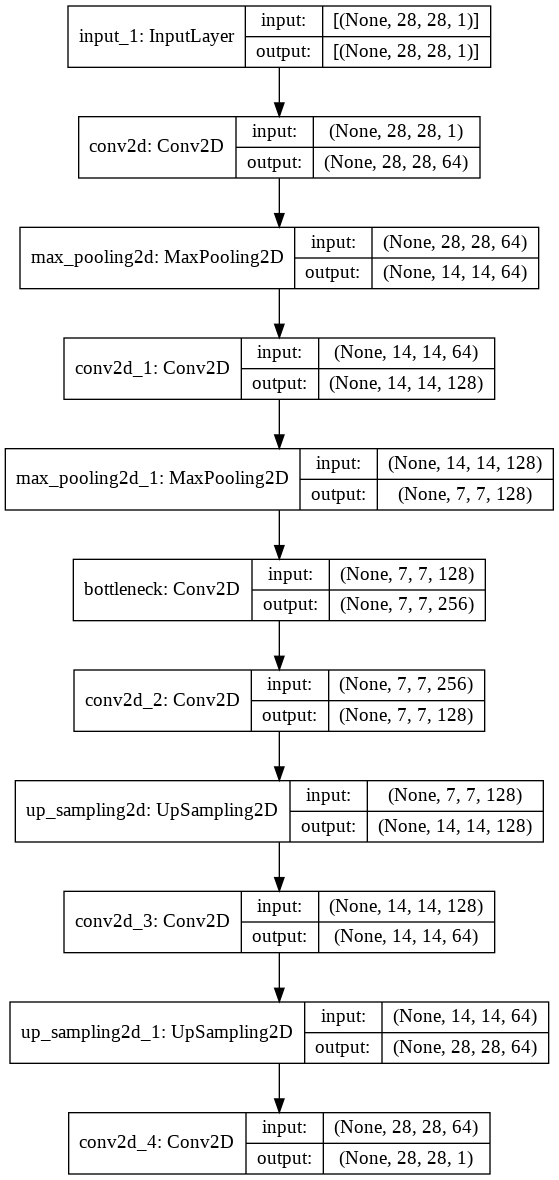

In [17]:
plot_model(autoencoder, show_shapes=True)

In [18]:
train_steps = len(X_train) // BATCH_SIZE 
val_steps = len(X_test) // BATCH_SIZE

history = autoencoder.fit(train_ds, steps_per_epoch=train_steps,
          validation_data=test_ds, validation_steps=val_steps, epochs=50)

Epoch 1/50
468/468 [==============================] - 21s 12ms/step - loss: 0.3091 - val_loss: 0.2915
Epoch 2/50
468/468 [==============================] - 6s 12ms/step - loss: 0.2863 - val_loss: 0.2860
Epoch 3/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2819 - val_loss: 0.2823
Epoch 4/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2793 - val_loss: 0.2808
Epoch 5/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2776 - val_loss: 0.2793
Epoch 6/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2765 - val_loss: 0.2791
Epoch 7/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2755 - val_loss: 0.2779
Epoch 8/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2750 - val_loss: 0.2772
Epoch 9/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2741 - val_loss: 0.2771
Epoch 10/50
468/468 [==============================] - 5s 12ms/step - loss: 0.2737 - val_l

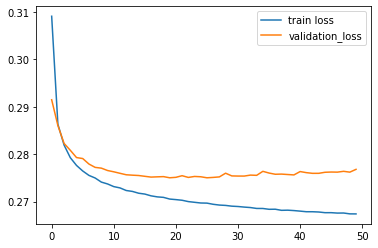

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()

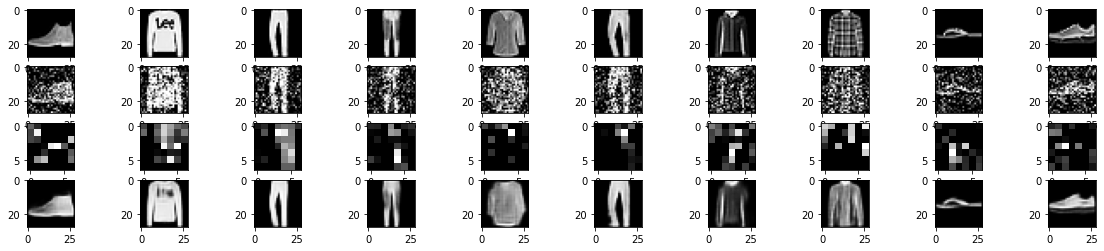

In [20]:
fig, ax = plt.subplots(4, 10, figsize=(20, 4))
cmap = 'gray' if X_test.shape[-1] == 1 else None
shape = X_test.shape[1:3] if X_test.shape[-1] == 1 else X_test.shape[1:]

for i in range(10):
    # original image
    ax[0, i].imshow(tf.reshape(X_test[i], shape), cmap=cmap)
    # noise added image
    ax[1, i].imshow(tf.reshape(X_test_noisy[i], shape), cmap=cmap)
    # encoder bottleneck image
    img = np.expand_dims(X_test_noisy[i], axis=0)
    ax[2, i].imshow(encoder_model.predict(img).reshape(encoder_viz.shape[1:3]), cmap=cmap)
    # decoder output image
    ax[3, i].imshow(autoencoder.predict(img).reshape(shape), cmap=cmap)